# Week 3: Geographic data visualization

In [54]:
library(tidyverse)
library(sf)
library(cartography)
library(tmap)
library(geosphere)
library(ggthemes)
library(classInt)

Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source'))`


## 0. Cartographic backgrounds
+ Coordinate systems
    + 체계
        + 지리좌표체계 (geographic coordinate systems): 구체 위의 위치를 숫자 쌍으로 나타내는 것
        + 투영좌표체계 (projected coordinate systems): 구체에 다양한 방법으로 평면을 접촉시켜 편 후 그 위치를 숫자 쌍으로 나타내는 것
    + 구성요소
        + 타원체 (spheroid): 복잡한 지구의 표면을 매끈한 표면으로 근사하기 위해 수학적으로 정의한 지구의 모형입니다.
            + 장반축 (axis major)
            + 단반축 (axis minor)
            + 편평도 (flatten ratio)
        + 투영원점 (origin of projection): 투영좌표계에서, 투영을 위해 투영면을 접촉시킨 기준점을 말합니다.
        + 동거와 북거 (easting and northing): 투영좌표계에서, 투영 후 좌표를 양수로 만들기 위하여 투영원점이 투영좌표계의 일정한 양수로 만드는 숫자를 말합니다. 동거는 동쪽 방향 (X)으로 더한 숫자이고 북거는 북쪽 방향 (Y)으로 더한 숫자입니다.
+ Reprojection / Coordinate system transformation
    + 좌표계에서 다른 좌표계로의 변환은 크게 두 가지로 나누어서 볼 수 있습니다.
        + 지리좌표체계의 데이텀 (datum) 간 변환
        + 투영좌표체계 간의 변환: 지리좌표체계 간의 데이텀 변환을 포함할 수 있습니다.
![](https://www.e-education.psu.edu/natureofgeoinfo/sites/www.e-education.psu.edu.natureofgeoinfo/files/image/projection.gif)
![](https://kartoweb.itc.nl/geometrics/Bitmaps/coordtrans%20projection%20change1.gif)


+ Coordinate systems in Korea        
    + 국제통용 좌표계: UTM Zone 52N
    + [한국의 좌표계](http://www.osgeo.kr/17)
        + 대부분 
        + 원점의 상대적 위치에 따라
            + 중부원점
            + 동부원점
            + 서부원점
            + 동해(울릉)원점
        + 타원체 데이텀에 따라
            + 1985년 한국측지계
            + 개정 한국측지계
            + 세계측지계
+ 기초 좌표계
    + 극좌표계
+ 좌표계의 코드체계
    + [EPSG (European Petroleum and Surveyor Group)](http://www.epsg.org/) 체계: IOGP (International Association of Oil and Gas Producers)에서 관리하는 세계 지리/투영좌표계의 코드분류체계
    + EPSG의 주요 좌표계
        + `epsg:4326`: WGS 1984
        + `epsg:3857`: Transverse Mercator (Google TM)
        + `epsg:5179`: 2000년 중부원점 (동거, 북거=1000000, 2000000)
        + `epsg:5174`: 1985년 중부원점 (동거, 북거=200000, 500000)
        + `epsg:5186`: 2000년 중부원점 (동거, 북거=400000, 600000)
        + `epsg:32652`: UTM Zone 52N

+ 좌표계는 우리가 지도를 통해 전달하려는 메시지를 조절할 수 있는 가장 중요하면서도 간편한 조절변수입니다.

## 1. Data-driven spatial objects: `sf` object
+ `sf` 패키지는 근래 R에서 공간정보를 저장, 교환, 처리하기 위한 보편적인 방법을 제공하는 패키지입니다.
+ `sf` 패키지와 `tidyverse`의 적절한 조화로 데이터 처리와 기하정보 처리(geoprocessing)를 손쉽게 수행할 수 있습니다.
+ [`ggplot2`](https://cran.r-project.org/web/packages/ggplot2/index.html)의 최신 버전(3.0.0) 에서는 `sf` 객체를 `ggplot2`에서도 별도 처리 없이 쉽게 지도로 표시할 수 있게 해 줍니다. 7월 5일에 발표된 버전이므로 새로 설치해 주시기 바랍니다. `repos` 설정을 잊지 마십시오.
+ 기본 기하정보
    + `st_point`, `st_multipoint`
    + `st_linestring`, `st_multilinestring`
    + `st_polygon`, `st_multipolygon`
+ 아래에서는 `sf` 패키지와 객체를 이용한 지도화와 기본적인 변환 작업에 관해 익히게 되는데, 그 전에 주요 함수들을 미리 눈에 익혀 둡시다.
    + __좌표계 변환: `st_transform`__; 변환이나 정의 시 epsg 코드를 잘 알아 두면 큰 도움이 됩니다.
    + __좌표계 정의: `st_crs`__; 좌표계가 정의되지 않았거나 `sf` 패키지에서 인식하지 못할 경우에 정의를 위해 사용하는 함수입니다.
    + __중심점 추출: `st_centroid`__; geometry의 무게중심을 추출하는 함수입니다. `of_largest_polygon` 매개변수로 
    + 주요 geometry 처리
        + `st_buffer`: 점, 선, 면으로부터 일정한 거리만큼 넓힌 폴리곤을 만들어 주는 함수입니다.
        + `st_intersection`: 여러 geometry 간의 중첩을 수행하는 함수입니다.
        + `st_union`: 여러 geometry(주로 폴리곤)를 융합시켜 모든 중첩부분을 제거하는 함수입니다.
        + `st_disjoint`: 여러 geometry들의 공통 부분을 뺀 나머지를 추출하는 함수입니다.
        + `st_difference`: 여러 geometry들의 차이를 조사하는 함수입니다.
    + 공간 조인: `st_join`; 점 위의 선, 선 위의 면, 면 위의 선, 면 위의 점 등, 공간적 관계에 따라서 속성들을 조인해 주는 함수입니다.
    + geometry 파생정보 추출: `st_coordinate`, `st_area`, `st_length`

## 2. Choropleth maps

In [12]:
dong_s <- st_read('C:/Users/sigma/Dropbox/Chores/2018S/GeoCONDA/W3/Dong_House.shp')

Reading layer `Dong_House' from data source `C:\Users\sigma\Dropbox\Chores\2018S\GeoCONDA\W3\Dong_House.shp' using driver `ESRI Shapefile'
Simple feature collection with 424 features and 12 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 126.7643 ymin: 37.42849 xmax: 127.1836 ymax: 37.70138
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


### 의미
+ 단계구분도: 속성값을 일정한 단계에 따라 나누고, 고유한 시각적 속성으로 지도를 작성하는 방법입니다.
+ 단계구분도는 말하자면 연속적인 속성값을 일정한 색상이 부여된 여러 개의 범주로 나누어 표현하는 방법입니다.
+ 단계구분도의 단계 수는 보통 '최대 7개까지'가 권장됩니다 (전화번호를 떠올려 보십시오). `tmap` 패키지에서는 5개가 기본값으로 설정되어 있습니다.
+ 속성 분류법을 이해하면 단계구분도에서 표현하려는 메시지를 좀 더 명확하게 만들 수 있습니다. 물론 좋은 의미에서와 나쁜 의미 모두를 포함해서 말입니다.
    + 등간격 (equal interval): 같은 간격으로 계급을 분류하는 방법
    + 등개수 (quantile): 계급에 들어가는 속성값의 개수를 같은 수로 만드는 방법
    + 표준편차 분류 (standard deviation): 평균으로부터 단위 표준편차 거리에 따라서 계급을 분류하는 방법
    + 클러스터 분류 (clustering): 속성값을 수학적으로 동질적인 계급으로 분류하는 방법
        + k-means(k개의 군집을 설정하고 알고리즘으로 값들을 분류해내는 방법)
        + Fisher-Jenks 방법: 군집 내부의 차이를 최소화하고, 군집 사이의 차이를 최대화하는 분류법
    + 특이 분류 (unique classification): 특정한 의미를 가지는 값을 기준으로 분류하는 방법

In [45]:
dong_gg <- ggplot(data = dong_s) +
    geom_sf(mapping = aes(fill = h_total), col = 'grey', lwd = 0.25) +
    theme_minimal()

dong_gg_h1 <- ggplot(data = dong_s) +
    geom_sf(mapping = aes(fill = h_p1), col = 'white', lwd = 0.2) +
    scale_color_continuous(low = 'white', high = 'red')
    #scale_color_continuous_tableau(palette = 'Red')# +
    #scale_color_continuous_tableau()
#colorRampPalette(c('white', 'red'))(100)

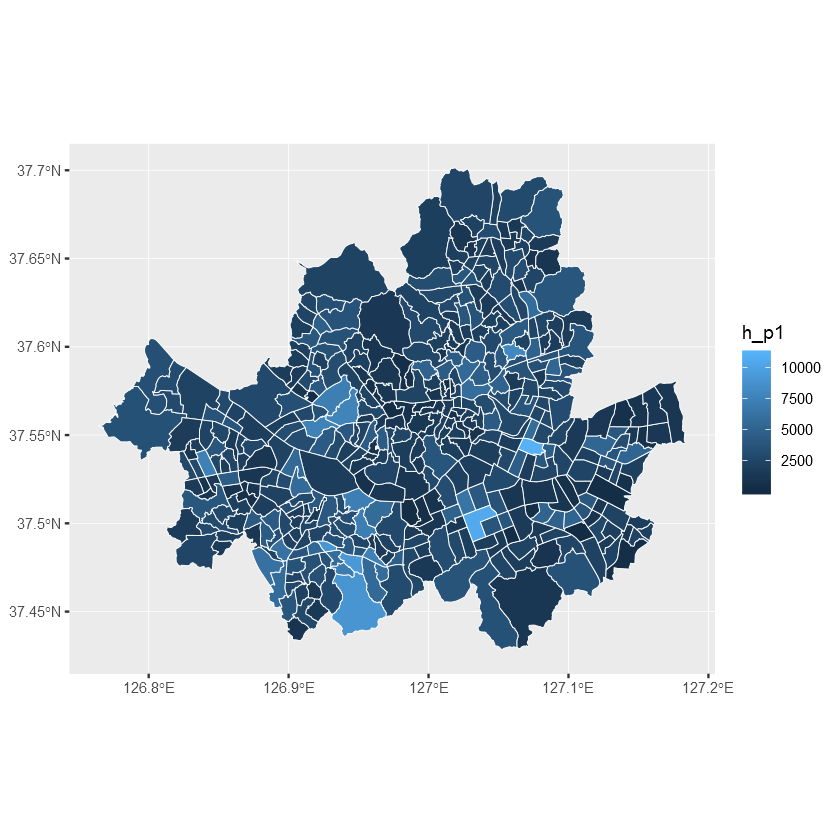

In [46]:
dong_gg_h1

### 위 지도의 특징
+ `ggplot2` 3.0.0 버전을 이용하여 `sf` 객체에 들어 있는 '1인가구 수'를 시각화한 것입니다.
+ 세부 조정을 하지 않는 한, 위 그림에서처럼 각 축에 경위도를 표시해 줍니다.
+ 아직까지 분류법을 적용하는 기능이 없어, 속성값이 비분류법의 연속적 색상으로 표시되었습니다.

### 분류법의 실제: 확인
+ 아래 몇 개의 예제는 `tmap` 패키지를 이용해서 위의 내용을 서로 다른 분류법을 적용해서 지도화하는 내용입니다.
    + 첫 번째 예제에서는 색상표 (color ramp)를 직접 만들어볼 수 있는 예제를 포함했습니다.
    + `colorRampPalette(color_list)(ncolors)`
        + `color_list`: 색상의 HTML 코드나, R에서 인식할 수 있는 색상의 이름 또는 색상 번호의 벡터입니다.
        + `ncolors`: 팔레트를 만들 색상의 개수입니다. 아래 첫 번째 예시에서는 100개를 만들도록 했지만, `tmap` 패키지에서 기본값으로 5개의 계급만 표시하도록 강제하기 때문에 다섯 가지 대표색이 선택되었음을 알 수 있습니다.
+ 범례 아래에는 분류법의 특징을 확인할 수 있는 히스토그램이 표시되어 있습니다.
    + 히스토그램을 보면서 분류법에 따라 계급에 속하는 속성값의 수와 색상이 공간적으로 표시되는 양상이 달라지는 패턴을 관찰해 보십시오.

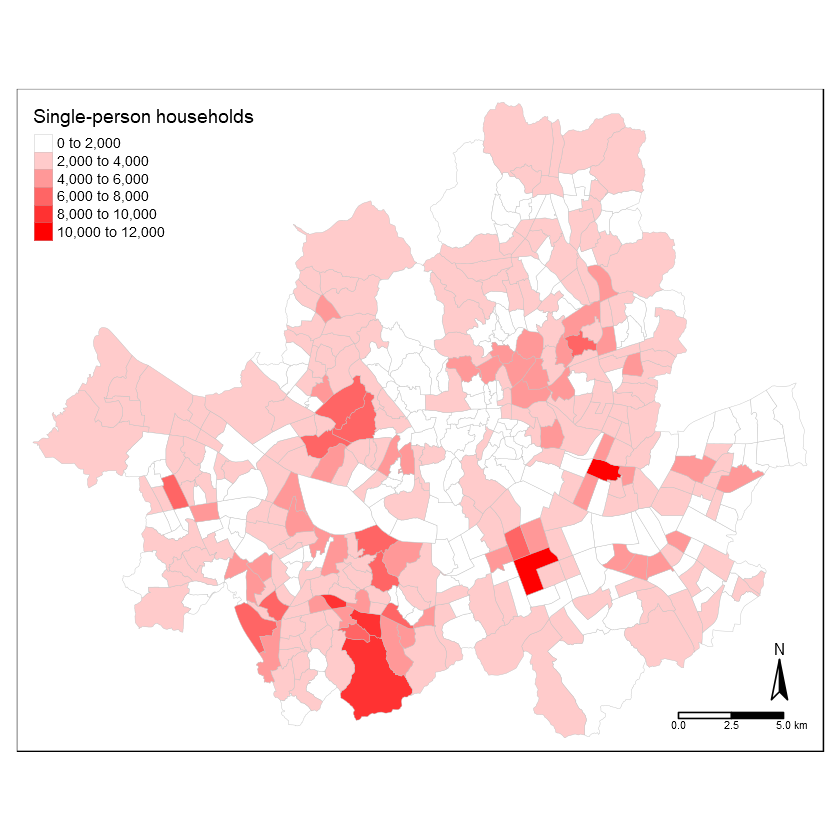

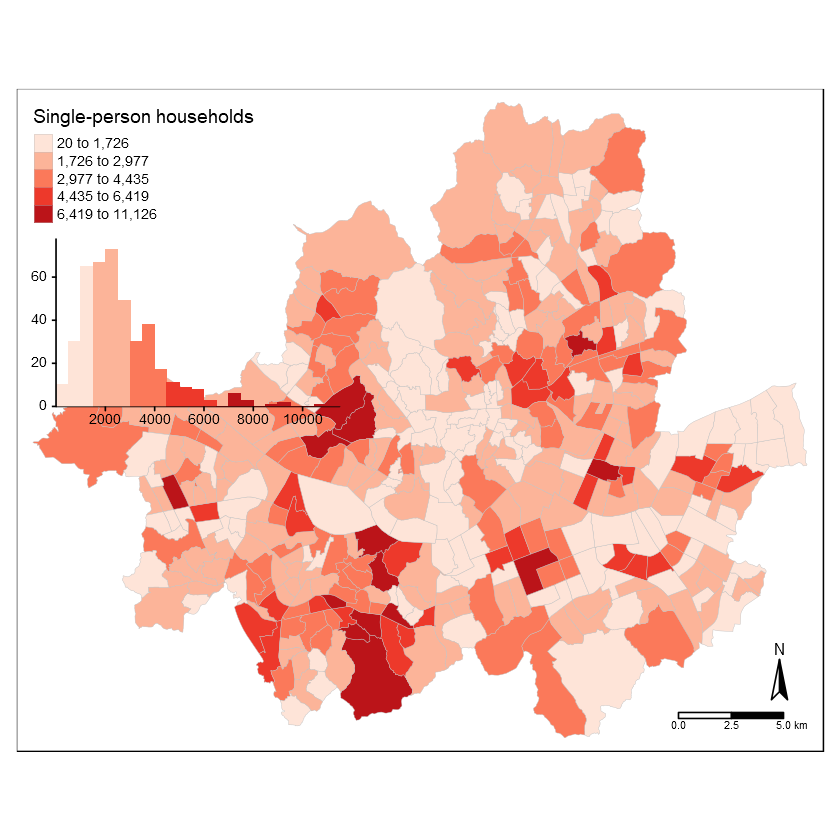

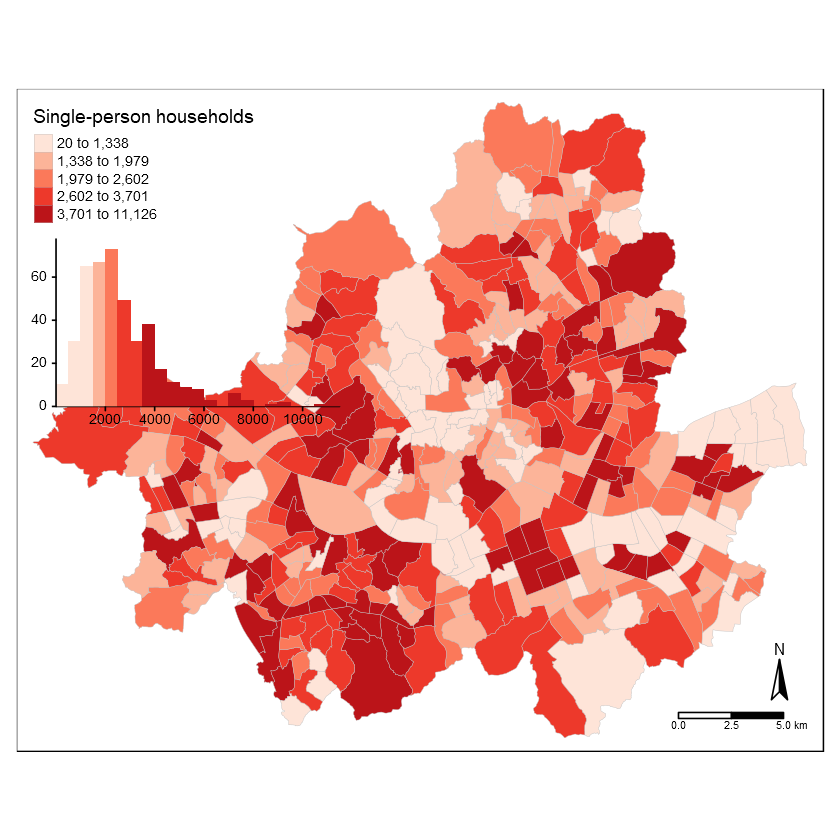

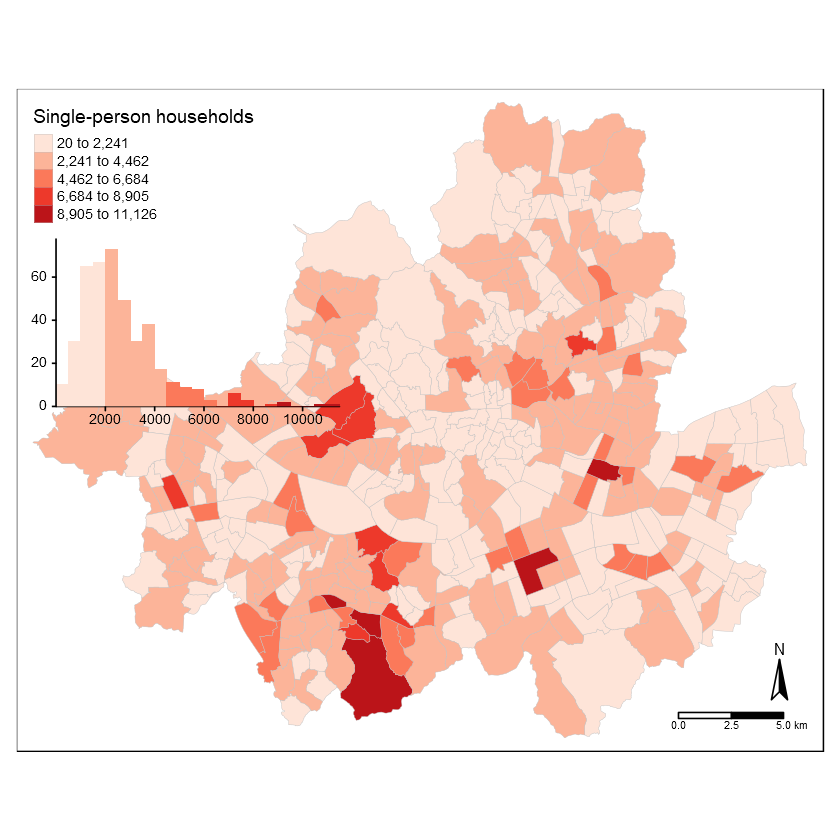

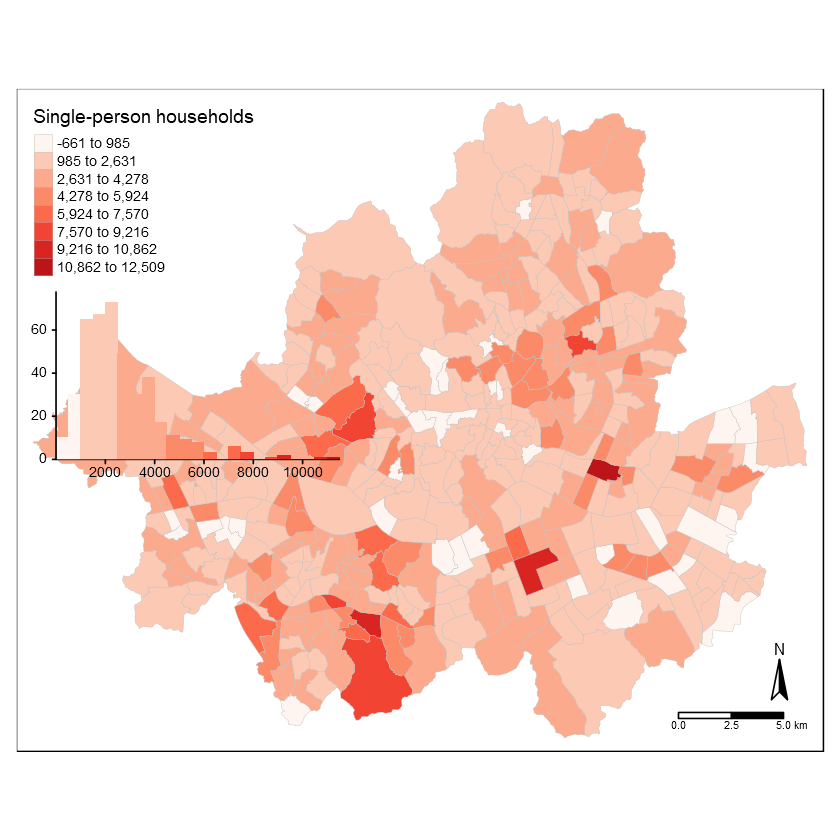

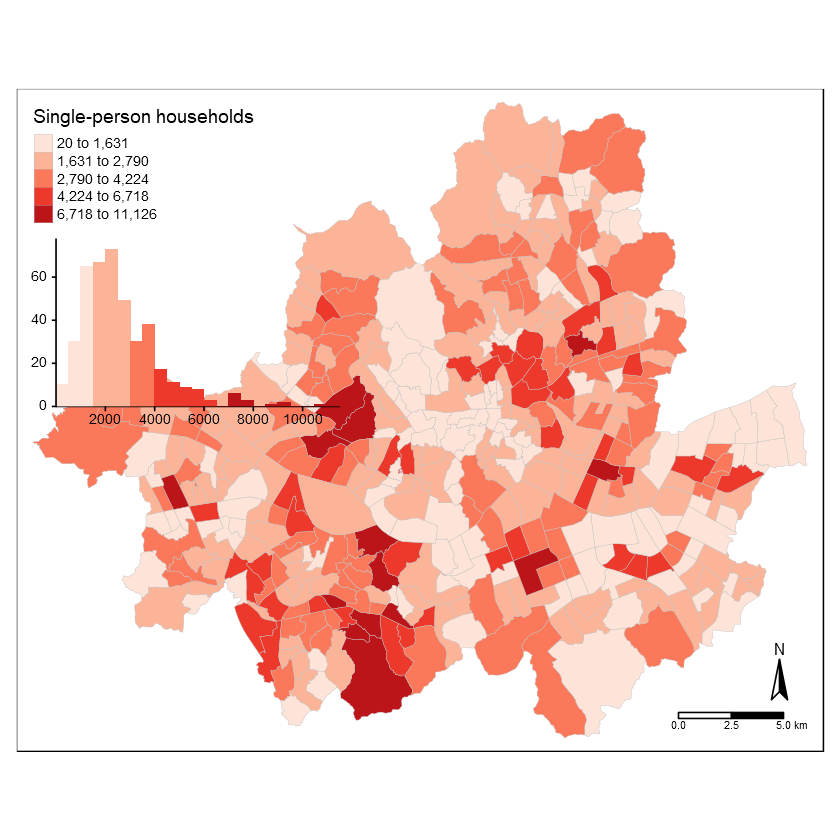

In [56]:
tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = colorRampPalette(c('white', 'red'))(100), title = 'Single-person households') +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))


tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = 'Reds', 
            style = 'jenks', title = 'Single-person households', legend.hist = TRUE) +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))

tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = 'Reds', 
            style = 'quantile', title = 'Single-person households', legend.hist = TRUE) +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))

tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = 'Reds', 
            style = 'equal', title = 'Single-person households', legend.hist = TRUE) +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))

tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = 'Reds', 
            style = 'sd', title = 'Single-person households', legend.hist = TRUE) +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))



tm_shape(dong_s) +
    tm_fill(col = 'h_p1', palette = 'Reds', 
            style = 'kmeans', title = 'Single-person households', legend.hist = TRUE) +
    tm_borders(col = 'grey', lwd = 0.25) +
    tm_compass() + 
    tm_scale_bar(breaks = c(0, 2.5, 5))

## 3. Cartogram
+ 카토그램 (등밀도지도): 속성값과 지역 면적 간의 관계를 일정하게 만들기 위하여 속성값에 따라 지역의 면적 또는 기호 크기를 왜곡하여 표시한 지도입니다.
    + 면적의 왜곡: 'Rubbersheet algorithm'(Dougenik et al. 1985) 이라는 꼭지점 이동 알고리즘으로 면을 구성하는 점들을 이동시킵니다. 
+ `cartogram` 패키지의 `cartogram` 함수
    + 먼저 설치를 완료하고 나서, 아래의 요령으로 실행합니다.
    + 참고로, `cartogram` 함수에 들어가는 `sf` 객체는 `epsg:4326`이 아닌 투영좌표계 중 하나여야만 올바른 결과를 산출합니다.
    + 아래 예제는 서울특별시 행정동의 1인가구 수(필드명 `h_p1`)를 대상으로 카토그램을 제작하는 과정을 보여줍니다. 아래 사항을 유의하여 보십시오:
        + 알 수 없는 이유로 Jupyter notebook 상에서 `cartogram`이 실행되지 않으므로, 주어진 파일을 이용해서 아래 코드 블록을 실행해 보십시오.
        + 원본 데이터는 `epsg:4326`으로 되어 있습니다. 우리는 이 자료를 `epsg:5179`로 재투영할 것입니다. `st_transform`의 용례를 잘 확인해 보십시오.
        + 알고리즘 수행에는 매우 긴 시간이 소요되므로, 임의로 반복횟수를 아주 작게 설정했습니다. 충분한 시간을 가지고 반복 횟수를 늘려 보면서 변화를 확인하십시오.

In [66]:
library(cartogram)
dong_ss <- st_transform(dong_s, crs = 5179)
# epsg 코드만 알면 st_transform을 정확하고 빠르게 사용할 수 있습니다.

In [62]:
dong_scg <- cartogram::cartogram(dong_ss, 'h_p1', 10)
plot(dong_scg)

tm_shape(dong_scg) +
tm_fill('h_p1', style = 'jenks') +
tm_border('grey', lwd= 0.33) 

Mean size error for iteration 1: 2.0960366282669


ERROR: Error in pts[, c("L1", "L2", "L3")]: subscript out of bounds


## 4. Flow map for trade data
### Intro
+ 이번 장에서는 여러 시각화 방법들을 되새기면서 폐플라스틱 교역에 대한 유선도를 작성해 보겠습니다.
+ 유선도란, 두 지점 혹은 여러 지점 간의 관계를 선의 형태로 표시하는 지도로, 이 장에서 사용할 자료처럼 흐름을 나타내는 데 적합합니다.
+ 이 지도에 많은 정보들이 담기므로, 유선도를 작성하기가 위에서 `tmap`을 이용해서 단계구분도를 작성하는 것만큼 쉽지는 않습니다. 하지만 여러분은 지금까지 배웠던 데이터 가공과 일반 시각화 방법들을 되새기면서, 아래 예제들을 이용하여 여러분만의 유선도를 작성할 수 있게 될 것입니다.
    
### Design
+ 우리는 본격적인 제작 과정에 들어가기 전에 유선도의 구성요소들을 분해할 필요가 있습니다. 퍼뜩 다음 몇 가지 요소들이 떠오릅니다.
    + 배경지도: '세계' 무역 자료인 만큼, 세계 지도가 필요하겠지요.
    + 대표점: 국가 간의 교역관계를 나타내려면 국가를 대표하는 어떤 기준점이 필요하리라 예상할 수 있겠습니다.
    + 유선: 국가들을 잇는 선을 어떻게 표시할 것인가도 문제입니다. 여기에서는 일단 소위 '대권항로'라 부르는 최단거리 표시선을 이용하겠습니다. 이를 위해 `geosphere`라는 패키지가 필요합니다.
+ 다음으로, 데이터 측면에서 몇 가지를 고민해야 합니다.
    + 소규모 교역국의 처리: 지난 시간에 살펴보았듯이 교역국에 따라서 교역 규모가 천양지차입니다. 이러한 점을 볼 때, 너무 교역량이 작은 국가들은 오히려 시각화하려는 현상에 교란(noise)이 될 수 있습니다. 아래 사례에서는 교란 요소인 소규모 교역국을 제외하겠습니다.
    + 자료의 형태: 일단 교역이 양자 간 관계를 기본으로 한다는 점을 상기한다면, 데이터 측면에서 양자 간의 관계로 축약해야 합니다. 다행히도 우리가 가지고 있는 자료는 양자 간의 관계로 되어 있습니다.
+ 여러 고민 끝에 우리는 다음과 같은 방식으로 유선도를 만들고자 합니다.
    + 세계 전도를 기반으로, 국가의 대표점을 국가의 가장 큰 영토 부분의 중심점(centroid)으로 하여,
    + 교역보고국(Reporter)을 한국(ISO Alpha-3: KOR)으로 한 뒤,
    + 50% quantile 이하의 교역국을 모두 제외하고 유선도로 교역국들을 나타내되,
    + 시각적 속성을 선의 굵기로 하여 교역량을 구분합니다.

In [80]:
world_s <- st_read('D:/0_Data/GADM/gadm28_adm0.shp')

Reading layer `gadm28_adm0' from data source `D:\0_Data\GADM\gadm28_adm0.shp' using driver `ESRI Shapefile'
Simple feature collection with 256 features and 70 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.65833
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


+ 제공된 GADM (Database of Global Administrative Areas) 경계는 Level-0 자료로서, '국가(countries)' 단위의 면형 자료입니다.
+ 자료를 효율적으로 사용하고자 `st_simplify`를 이용해서 경계를 단순화합니다.
+ 아래 코드에서는 `epsg:4326`을 기준으로 꼭지점 단순화 기준을 0.0025도로 설정했습니다. 1도가 중위도에서 110km정도 된다는 것을 상기한다면, 0.0025도는 대략 275m가 됩니다 (고위도로 가면 더 짧아질 것이고 저위도로 간다면 더 길어질 것입니다). 상당한 단순화이지만, 우리가 워낙 소축척 지도를 그리려 하기 때문에 큰 문제는 없습니다.

In [81]:
world_sim <- st_simplify(world_s, preserveTopology = TRUE, dTolerance = 0.0025)
# dTolerance: 꼭지점을 얼마만큼의 간격으로 단순화할 것인가(즉, 삭제할 것인가)에 대한 인수입니다.
# 0.0025는 4326 좌표계의 0.0025도를 의미하며, 미터법으로 환산 시 대략 270~300m가 됩니다.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsWarning message in st_simplify.sfc(st_geometry(x), preserveTopology, dTolerance):
"st_simplify does not correctly simplify longitude/latitude data, dTolerance needs to be in decimal degrees"

Warning message:
"plotting the first 10 out of 70 attributes; use max.plot = 70 to plot all"

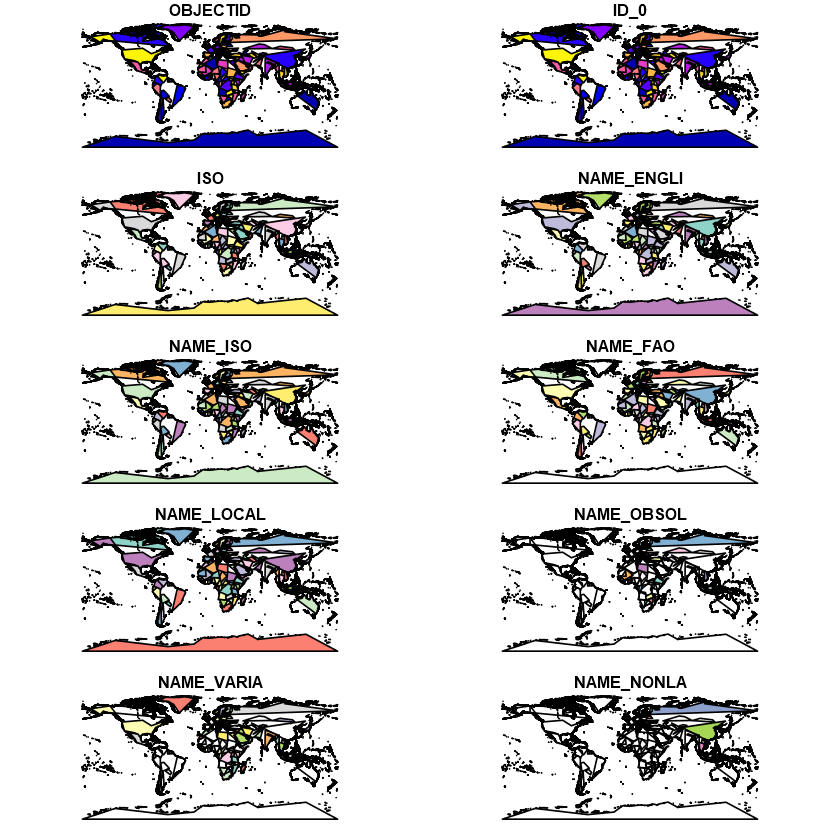

In [10]:
#plot(world_s)
# 매우 오래 걸립니다.

In [75]:
world_sim

OBJECTID,ID_0,ISO,NAME_ENGLI,NAME_ISO,NAME_FAO,NAME_LOCAL,NAME_OBSOL,NAME_VARIA,NAME_NONLA,geometry,...,CAN,ACP,Landlocked,AOSIS,SIDS,Islands,LDC,Shape_Leng,Shape_Area,geometry
1,1,AFG,Afghanistan,AFGHANISTAN,Afghanistan,Afghanestan,NA,NA,NA,POLYGON ((71.00423 38.47541...,...,0,0,1,0,0,0,1,57.1046546,6.274959e+01,POLYGON ((71.00423 38.47541...
2,2,XAD,Akrotiri and Dhekelia,AKROTIRI AND DHEKELIA,NA,Akrotiri and Dhekelia,NA,NA,NA,MULTIPOLYGON (((32.83562 34...,...,0,0,0,0,0,0,0,2.1990582,2.310599e-02,MULTIPOLYGON (((32.83562 34...
3,3,ALA,Åland,ÅLAND ISLANDS,NA,Åland,NA,Åland Islands,NA,MULTIPOLYGON (((21.32361 59...,...,0,0,0,0,0,1,0,42.5564488,2.437771e-01,MULTIPOLYGON (((21.32361 59...
4,4,ALB,Albania,ALBANIA,Albania,Shqiperia,NA,Shqipëria,NA,MULTIPOLYGON (((19.99181 39...,...,0,0,0,0,0,0,0,14.0334055,3.082172e+00,MULTIPOLYGON (((19.99181 39...
5,5,DZA,Algeria,ALGERIA,Algeria,Al Jaza'ir,NA,NA,NA,MULTIPOLYGON (((-1.630694 3...,...,0,1,0,0,0,0,0,82.6848552,2.126342e+02,MULTIPOLYGON (((-1.630694 3...
6,6,ASM,American Samoa,AMERICAN SAMOA,American Samoa,American Samoa,NA,NA,NA,MULTIPOLYGON (((-168.145 -1...,...,0,0,0,0,1,1,0,2.1754811,1.870871e-02,MULTIPOLYGON (((-168.145 -1...
7,7,AND,Andorra,ANDORRA,Andorra,Andorra,NA,NA,NA,POLYGON ((1.575307 42.64737...,...,0,0,1,0,0,0,0,1.2221162,4.953098e-02,POLYGON ((1.575307 42.64737...
8,8,AGO,Angola,ANGOLA,Angola,Angola,NA,NA,NA,MULTIPOLYGON (((11.70236 -1...,...,0,0,0,0,0,0,1,73.5319460,1.038400e+02,MULTIPOLYGON (((11.70236 -1...
9,9,AIA,Anguilla,ANGUILLA,NA,Anguilla,NA,NA,NA,MULTIPOLYGON (((-63.42375 1...,...,0,0,0,0,1,1,0,1.3183212,7.115669e-03,MULTIPOLYGON (((-63.42375 1...
10,10,ATA,Antarctica,ANTARCTICA,NA,Antarctica,NA,NA,NA,MULTIPOLYGON (((177.912 -59...,...,0,0,0,0,0,0,0,2306.9916157,6.052118e+03,MULTIPOLYGON (((177.912 -59...


### Centroid extraction

In [82]:
world_sc <- st_centroid(world_s, of_largest_polygon = TRUE)

Warning message in st_centroid.sf(world_s, of_largest_polygon = TRUE):
"st_centroid assumes attributes are constant over geometries of x"Warning message in st_centroid.sfc(st_geometry(x), of_largest_polygon = of_largest_polygon):
"st_centroid does not give correct centroids for longitude/latitude data"Warning message:
"Column `ISO`/`Partner` joining factor and character vector, coercing into character vector"

In [85]:
aeqd_crs <- '+proj=aeqd +lat_0=37.5 +lon_0=127.5 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs'

In [90]:
world_aeq <- st_transform(world_sim, st_crs(aeqd_crs))

ERROR: Error: invalid crs: +proj=aeqd +lat_0=37.5 +lon_0=127.5 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs, reason: unknown unit conversion id


In [70]:
pla <- read_csv('C:/Users/sigma/Dropbox/Chores/2018S/GeoCONDA/W1/Plastic_trade.csv',
               col_type = 'cccnnicc')
head(pla)

Flow,Reporter,Partner,Netweight_kg,Value_usd,year,Reporter_nm,Partner_nm
Import,ALB,BGR,124190,107621,2010,ALBANIA,BULGARIA
Export,ALB,CHN,812861,425149,2010,ALBANIA,CHINA
Import,ALB,DEU,2347640,943464,2010,ALBANIA,GERMANY
Export,ALB,DEU,678160,349723,2010,ALBANIA,GERMANY
Import,ALB,GRC,1516306,647468,2010,ALBANIA,GREECE
Import,ALB,ITA,65626,29150,2010,ALBANIA,ITALY


In [119]:
pla_exp <- pla %>% 
    filter(Reporter == 'KOR' & Flow == 'Export' & year == 2015) %>% 
    filter(Value_usd >= quantile(Value_usd, 0.5))
pla_imp <- pla %>% 
    filter(Reporter == 'KOR' & Flow == 'Import' & year == 2015) %>% 
    filter(Value_usd >= quantile(Value_usd, 0.5))
dim(pla_exp)
dim(pla_imp)


[1] 10  8

[1] 23  8

In [120]:
world_sc <- world_sc %>% 
    left_join(pla_exp, by = c('ISO' = 'Partner')) %>%
    rename(Export = Value_usd) %>%
    left_join(pla_imp, by = c('ISO' = 'Partner')) %>%
    rename(Import = Value_usd)

In [94]:
world_sc <- world_sc
world_scc <- world_sc %>% st_coordinates
world_sc <- world_sc %>% bind_cols(as.data.frame(world_scc))
world_sc_i <- world_sc %>% filter(!is.na(Import))
world_sc_e <- world_sc %>% filter(!is.na(Export))
kor_pnts <- world_sc %>% filter(ISO == 'KOR')
kor_pntsc <- st_coordinates(kor_pnts)
kor_pnts <- bind_cols(kor_pnts, as.data.frame(kor_pntsc))

In [95]:
world_sc %>% colnames
world_sc_i %>% colnames

[1] "OBJECTID"       "ID_0"           "ISO"            "NAME_ENGLI"    
 [5] "NAME_ISO"       "NAME_FAO"       "NAME_LOCAL"     "NAME_OBSOL"    
 [9] "NAME_VARIA"     "NAME_NONLA"     "NAME_FRENC"     "NAME_SPANI"    
[13] "NAME_RUSSI"     "NAME_ARABI"     "NAME_CHINE"     "WASPARTOF"     
[17] "CONTAINS"       "SOVEREIGN"      "ISO2"           "WWW"           
[21] "FIPS"           "ISON"           "VALIDFR"        "VALIDTO"       
[25] "POP2000"        "SQKM"           "POPSQKM"        "UNREGION1"     
[29] "UNREGION2"      "DEVELOPING"     "CIS"            "Transition"    
[33] "OECD"           "WBREGION"       "WBINCOME"       "WBDEBT"        
[37] "WBOTHER"        "CEEAC"          "CEMAC"          "CEPLG"         
[41] "COMESA"         "EAC"            "ECOWAS"         "IGAD"          
[45] "IOC"            "MRU"            "SACU"           "UEMOA"         
[49] "UMA"            "PALOP"          "PARTA"          "CACM"          
[53] "EurAsEC"        "Agadir"         "SAARC"          "ASEAN"         
[57] "NAFTA"          "GCC"            "CSN"            "CARICOM"       
[61] "EU"             "CAN"            "ACP"            "Landlocked"    
[65] "AOSIS"          "SIDS"           "Islands"        "LDC"           
[69] "Shape_Leng"     "Shape_Area"     "Flow.x"         "Reporter.x"    
[73] "Netweight_kg.x" "Export"         "year.x"         "Reporter_nm.x" 
[77] "Partner_nm.x"   "Flow.y"         "Reporter.y"     "Netweight_kg.y"
[81] "Import"         "year.y"         "Reporter_nm.y"  "Partner_nm.y"  
[85] "geometry"       "X"              "Y"

[1] "OBJECTID"       "ID_0"           "ISO"            "NAME_ENGLI"    
 [5] "NAME_ISO"       "NAME_FAO"       "NAME_LOCAL"     "NAME_OBSOL"    
 [9] "NAME_VARIA"     "NAME_NONLA"     "NAME_FRENC"     "NAME_SPANI"    
[13] "NAME_RUSSI"     "NAME_ARABI"     "NAME_CHINE"     "WASPARTOF"     
[17] "CONTAINS"       "SOVEREIGN"      "ISO2"           "WWW"           
[21] "FIPS"           "ISON"           "VALIDFR"        "VALIDTO"       
[25] "POP2000"        "SQKM"           "POPSQKM"        "UNREGION1"     
[29] "UNREGION2"      "DEVELOPING"     "CIS"            "Transition"    
[33] "OECD"           "WBREGION"       "WBINCOME"       "WBDEBT"        
[37] "WBOTHER"        "CEEAC"          "CEMAC"          "CEPLG"         
[41] "COMESA"         "EAC"            "ECOWAS"         "IGAD"          
[45] "IOC"            "MRU"            "SACU"           "UEMOA"         
[49] "UMA"            "PALOP"          "PARTA"          "CACM"          
[53] "EurAsEC"        "Agadir"         "SAARC"          "ASEAN"         
[57] "NAFTA"          "GCC"            "CSN"            "CARICOM"       
[61] "EU"             "CAN"            "ACP"            "Landlocked"    
[65] "AOSIS"          "SIDS"           "Islands"        "LDC"           
[69] "Shape_Leng"     "Shape_Area"     "Flow.x"         "Reporter.x"    
[73] "Netweight_kg.x" "Export"         "year.x"         "Reporter_nm.x" 
[77] "Partner_nm.x"   "Flow.y"         "Reporter.y"     "Netweight_kg.y"
[81] "Import"         "year.y"         "Reporter_nm.y"  "Partner_nm.y"  
[85] "X"              "Y"              "geometry"

In [97]:
log(max(world_sc$Import, na.rm = T))
log(max(world_sc$Export, na.rm = T))

[1] 16.8246

[1] 17.847

In [116]:
plot_my_connection <- function(d1, d2, dep_lon, dep_lat, arr_lon, arr_lat, target_var = 'Import', wd = 2, color = 'slateblue'){
  d1 <- st_set_geometry(d1, NULL)
  d2 <- st_set_geometry(d2, NULL)
  inter <- gcIntermediate(c(d1[1,dep_lon], d1[1,dep_lat]), 
                          c(d2[1,arr_lon], d2[1,arr_lat]), n = 50, addStartEnd = TRUE, breakAtDateLine = F)             
  inter <- data.frame(inter)
  diff_of_lon <- abs(d1[1,dep_lon]) + abs(d2[1,arr_lon])
  lwds <- wd * exp(d1[1,target_var]/15)
  if(diff_of_lon > 180){
    lines(subset(inter, lon >= 0), lwd = lwds, col = color)
    lines(subset(inter, lon < 0), lwd = lwds, col = color)
  } else{
    lines(inter, lwd = lwds, col = color)
  }
}

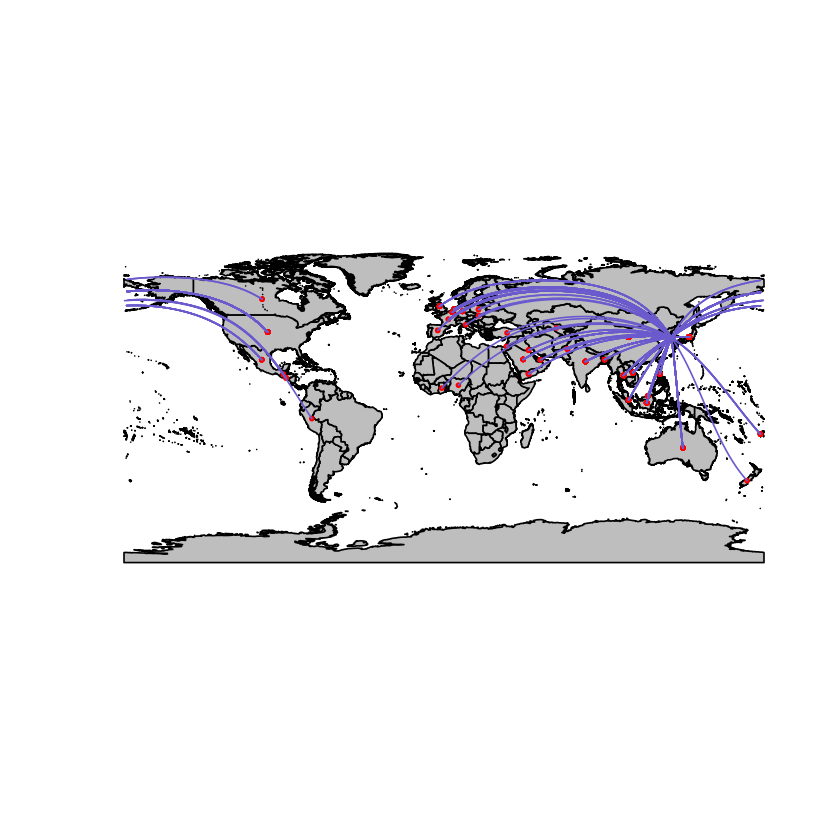

In [117]:
plot(st_geometry(world_sim), col = 'grey')
plot(st_geometry(world_sc_i), add = TRUE, pch = 19, cex = 0.33, col = 'red')
for (j in 1:nrow(world_sc_i)){plot_my_connection(kor_pnts, world_sc_i[j,],
                                                 'X','Y','X','Y')}


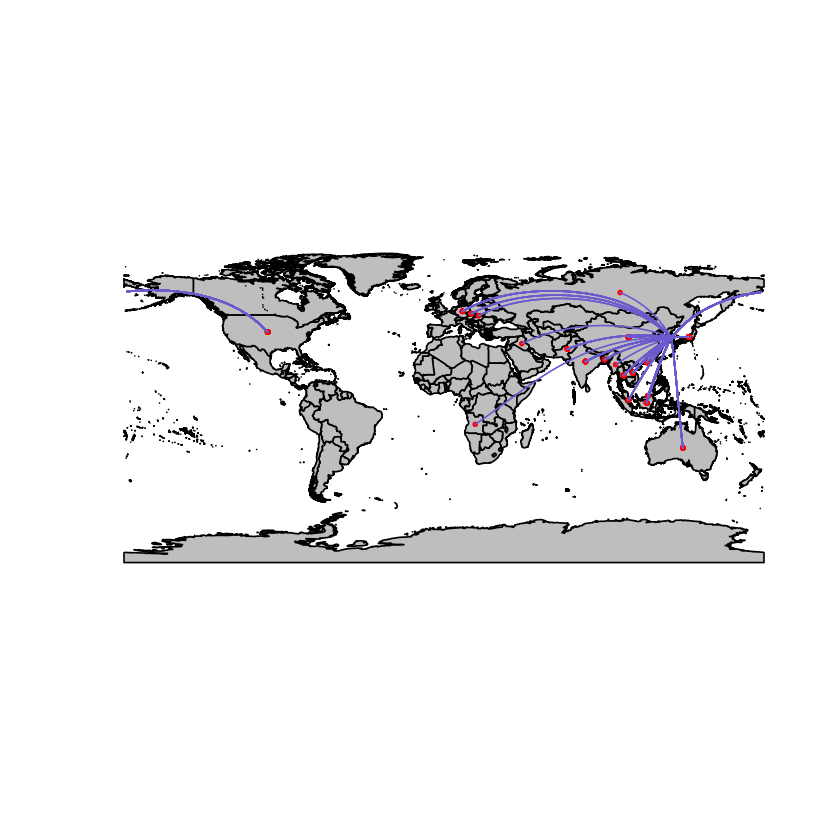

In [118]:
plot(st_geometry(world_sim), col = 'grey')
plot(st_geometry(world_sc_e), add = TRUE, pch = 19, cex = 0.33, col = 'red')
for (j in 1:nrow(world_sc_e)){plot_my_connection(kor_pnts, world_sc_e[j,],
                                                 'X','Y','X','Y')}


### Assignment
+ 단계구분도 작성법: 2분
    + 주어진 서울특별시 자료를 이용하여, 서울특별시 데이터센터에서 행정동 별 자료를 구득하시오.
    + 자료를 조인한 후, 적절한 속성 분류법을 적용하여 단계구분도 또는 카토그램을 작성하고, 그에 대해 간단히 설명하시오.
+ 유선도 평가와 작성 실습: 3분
    + 위 유선도의 예에서 이상한 점은 무엇인가? 사용한 데이터를 예로 들어 한 가지만 설명하시오.
    + 1주차 과제 자료를 이용하여 위의 예와 같은 유선도를 작성하시오. 그리고 그 유선도에 관해 간단히 설명하시오.